In [3]:
# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## How to define Betweeness resistance for different groups on a Graph?
Let's start on defining the betweenes for an individual node and the betweeness for a graph.

Let's define a graph as $G=\mathcal{(V,E)}$. Let's define a distance function between nodes as $f:V\times V\rightarrow R_{uv}$, having:

$$
R_{uv} =\sum_{i>0} \frac{1}{\lambda_i} \left(\phi_i(u)-\phi_i(v)\right)^2= (\mathbf{e_u}-\mathbf{e_v})^T L^+ (\mathbf{e_u}-\mathbf{e_v})= L^+_{uu} + L^+_{vv} - 2 L^+_{uv} = \frac{\tau(u,v)}{\text{vol}(G)}.
$$

The **betweness for a single node** is defined as (* see also conection with curvature as 1-(1/2)B):
$$
B_R(u) = \sum_{v\in\mathcal{N}(u)} R_{uv}
$$

In this scenario, we know that for the full graph, the total betwenees (sum of $R_{uv}$ for every edge) equals to N-1 being $N=|V|$: $\sum_{(u,v)\in\mathcal{E}} R_{uv} = |V|-1$

Therefore, if we want to compute the average $B_R(u)$ or the total $B_R(u)$ for a group, we should account for the **total betweness sum and avg betweness of the graph** first. First, the total sum is defined as.

$$
\sum_{u\in\mathcal{V}} B_R(u) = \sum_{u\in\mathcal{V}} \sum_{v\in\mathcal{N}(u)} R_{uv} = 2\times \sum_{(u,v)\in\mathcal{E}} R_{uv} = 2|V|-2
$$

and the expectance as
$$
\mathbb{E}_{u\sim V}[B_R(u)] = 2-\frac{2}{|V|}
$$

no matter the number of edges (density) of the graph.

**Expected Betweeness of a sub-graph**

Now, we have to analyze each subgraph with the following options:
1. How much betweness they provide to the total sum?

$$
B_R(S) = \frac{\sum_{u \in S} B_R(u)}{2|V|-2}\:\:\quad\text{and}\\
\sum_{S_i \in V} B_R(S_i) = 2|V|-2
$$
However it has some drawbacks since it does not account for the number of samples of each group. Therefore, if a group has 2/3 of the total number of nodes, their betweeness is how much they diverge from that expected $\frac{2}{3}(2|V|-2)$. If they have more than 2/3 they have more contrl than expected. If they have less, they have less control than expected. Therefore, the measurement of the control with the **expected control per node** is a better solution. We define it as follows.

2. What is their mean and and How much they diverge for the mean?

$$
B_R(S) = \frac{\sum_{u \in S} B_R(u)}{|S|}\:\:\quad\text{and}\\
\sum_{S_i \in V} |S_i|\times B_R(S_i)= 2|V|-2\:\:\quad\text{or}\:\:\quad\frac{1}{|V|}\sum_{S_i \in V} |S_i|\times B_R(S_i)= |V|-\frac{2}{|V|}
$$

knowing for this second one that the expected value is $|V|-\frac{2}{|V|}$. 

**A GROUP IS DISADVANTAGE IS THEIR MEAN CONTROL IS LESS THAN THE EXPECTED $|V|-\frac{2}{|V|}$. IT MEANS THAT, THEY HAVE LESS CONTROL THAT WE WOULD EXPECT FOR A GROUP WITH THAT SIZE. THE MAIN GOAL IS THAT EVERY GROUP HAS $|V|-\frac{2}{|V|}$ AVERAGE CONTROL, WHICH WILL BE TRANSLATED AS THAT EVERY GROUP HAS THE EXPECTED CONTROL REGARDING THEIR SIZE.** It does not mean that a every node in the graph have the same betweeness, since inside every group might be big differences.

**Additional info**
* If the edge is a cut then $R_{uv}=1$
* $R_{uv}$ is the probability that that edge appear in a random spanning tree $R_{uv}= \mathbb{P}[(u,v)\in \mathbf{T}]$
* The Betweeness of an node is $B_r(u) = \sum_{v \in \mathcal{N}(u)} R_{uv}= \sum_{v\in \mathcal{N}(u)} \mathbb{P}[(u,v)\in \mathbf{T}]$
* The Betweeness of an node is lower bounded by 1, since if I cut all the links, I isolate the node and I cut the graph.
* The betweenes has relationship eith the curvature since $\mathcal{K}(u) = 1 - \frac{1}{2} B_R(u)$
* The sum of all betweneess is 2N-2 and the sum of all curvatures is 1.
* The lower bound betweenes is 1 and the upper bound of curvature is 0.5

In [1]:
import utils.data_loader as loader
import utils.torch_resistance_metrics as ermet
import networkx as nx
import torch
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [12]:
ADD_N_EDGES = 7000
DRAW = True
DATASET = 'facebook'
DEVICE = 'cpu'

In [13]:
GW = loader.load_data(DATASET, device=DEVICE)
GW2 = loader.load_data(DATASET, device=DEVICE)
GW.num_edges, GW.num_nodes, GW2.num_edges, GW2.num_nodes

Loaded Graph with 1034 nodes and 26749 edges - L computation mode: exact
Loaded Graph with 1034 nodes and 26749 edges - L computation mode: exact


(26749, 1034, 26749, 1034)

In [55]:
u = 10
v = 12
GW.get_effective_resistance()[u,v].item(), GW.get_effective_resistance()[v,u].item()

(0.05579407885670662, 0.05579407513141632)

In [56]:
e_u = np.zeros(shape=(GW.num_nodes,1))
e_u[u] = 1
e_v = np.zeros(shape=(GW.num_nodes,1))
e_v[v] = 1
e_u.shape, e_v.shape

((1034, 1), (1034, 1))

In [57]:
(GW.pinv[u,u]-GW.pinv[v,u]) - (GW.pinv[v,u]-GW.pinv[v,v])

tensor(0.0558)

In [58]:
np.matmul(np.matmul((e_u-e_v).T,GW.pinv), (e_u-e_v))

tensor([[0.0558]], dtype=torch.float64)

In [59]:
GW.pinv[u,u]+GW.pinv[v,v]-2*GW.pinv[u,v]

tensor(0.0558)

In [62]:
(GW.pinv[u,:]-GW.pinv[v,:])[u] - (GW.pinv[u,:]-GW.pinv[v,:])[v]

tensor(0.0558)

In [174]:
N  =GW.num_nodes
TOTAL_TH_BW = 2*N -2
MEAN_TH_BW = TOTAL_TH_BW/N #2-2/N
TOTAL_TH_BW, MEAN_TH_BW, (2*N -2)/N, 2-2/N

(2066, 1.998065764023211, 1.998065764023211, 1.998065764023211)

In [175]:
R = GW.get_effective_resistance()

In [176]:
B = ermet.node_betwenness(R, ~GW.edge_mask)

In [177]:
B.sum(), TOTAL_TH_BW

(tensor(2066., device='cuda:0'), 2066)

In [178]:
from utils.link_addition_torch import get_weakest_link

In [179]:
betweenes_node = []

# Add ER diameters
for _ in tqdm(range(ADD_N_EDGES)):
    # get 2 random numbers between the range of 0 and num_nodes
    R2 = GW2.get_effective_resistance()

    u,v = get_weakest_link(R2.detach().cpu(), GW2.edge_mask.detach().cpu(), GW2.num_nodes)
    B = ermet.node_betwenness(R2.detach().cpu(), ~GW2.edge_mask.detach().cpu())
    betweenes_node.append(B)

    if GW2.is_edge(u,v):
        raise Exception('Edge already exists')
    else:
        GW2.add_link(u,v)

    
R2 = GW2.get_effective_resistance()
B = ermet.node_betwenness(R2.detach().cpu(), ~GW2.edge_mask.detach().cpu())
betweenes_node.append(B)
betweenes_node = torch.stack(betweenes_node)

100%|██████████| 7000/7000 [03:35<00:00, 32.55it/s]


In [180]:
betweenes_node.mean(axis=1)[:5],MEAN_TH_BW

(tensor([1.9981, 1.9981, 1.9981, 1.9981, 1.9981]), 1.998065764023211)

## distribution of betweenness centrality

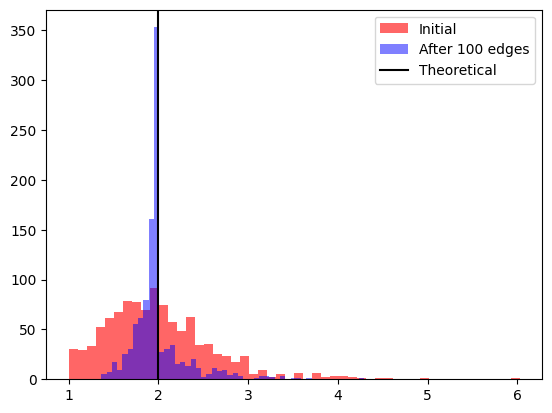

In [181]:
plt.hist(betweenes_node[0,:], bins=50, label='Initial', alpha=.6, color='red')
plt.hist(betweenes_node[-1,:], bins=50, label='After 100 edges', alpha=0.5, color='blue')
plt.axvline(x=MEAN_TH_BW, color='black', label='Theoretical')
plt.legend()
plt.show()

In [206]:
GW.sens.detach().cpu().unique().numpy()

array([0., 1.], dtype=float32)

In [232]:
np.linspace(0,6,10)

array([0.        , 0.66666667, 1.33333333, 2.        , 2.66666667,
       3.33333333, 4.        , 4.66666667, 5.33333333, 6.        ])

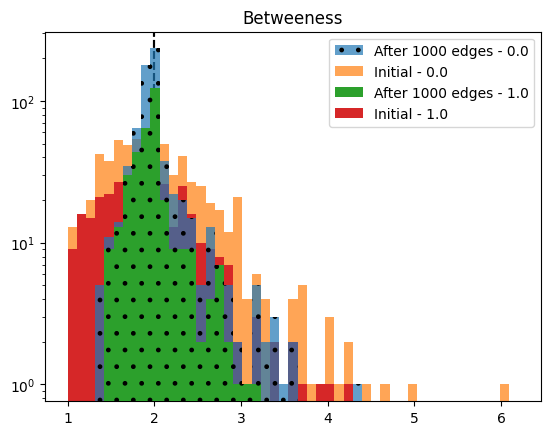

In [244]:

for group in GW.sens.detach().cpu().unique().numpy():
    alpha = .7 if group==0 else 1
    plt.hist(betweenes_node[-1,GW.sens.detach().cpu()==group], bins=np.linspace(1,6.2,50), label='After 1000 edges - '+str(group.item() ), alpha=alpha, hatch='.', zorder=10)
    plt.hist(betweenes_node[0,GW.sens.detach().cpu()==group], bins=np.linspace(1,6.2,50), label='Initial - '+str(group.item() ), alpha=alpha)
    plt.axvline(x=MEAN_TH_BW, color='black',linestyle='--')

plt.yscale('log')
plt.title(f'Betweeness')
plt.legend()
plt.show()

## Sum of betweenness for each group

In [246]:
print('Original Graph')
B0 = betweenes_node[0,GW.sens==0]
B1 = betweenes_node[0,GW.sens==1]
print(f'Group 0 sum: {B0.sum():.2f} -- Normalized: {B0.sum()/(2*N-2):.5f}')
print(f'Group 1 sum: {B1.sum():.2f}  -- Normalized: {B1.sum()/(2*N-2):.5f}')
print(f'B0+B1: {B0.sum()+B1.sum():.2f}{" "*7}-- Normalized: {(B0.sum()/(2*N-2))+(B1.sum()/(2*N-2)):.2f}')
print()


print(f'After {ADD_N_EDGES} edges added')
B0 = betweenes_node[-1,GW.sens==0]
B1 = betweenes_node[-1,GW.sens==1]
print(f'Group 0 sum: {B0.sum():.2f} -- Normalized: {B0.sum()/(2*N-2):.5f}')
print(f'Group 1 sum: {B1.sum():.2f}  -- Normalized: {B1.sum()/(2*N-2):.5f}')
print(f'B0+B1: {B0.sum()+B1.sum():.2f}{" "*7}-- Normalized: {(B0.sum()/(2*N-2))+(B1.sum()/(2*N-2)):.2f}')
print()

Original Graph
Group 0 sum: 1393.32 -- Normalized: 0.67441
Group 1 sum: 672.68  -- Normalized: 0.32559
B0+B1: 2066.00       -- Normalized: 1.00

After 500 edges added
Group 0 sum: 1386.77 -- Normalized: 0.67123
Group 1 sum: 679.23  -- Normalized: 0.32877
B0+B1: 2066.00       -- Normalized: 1.00



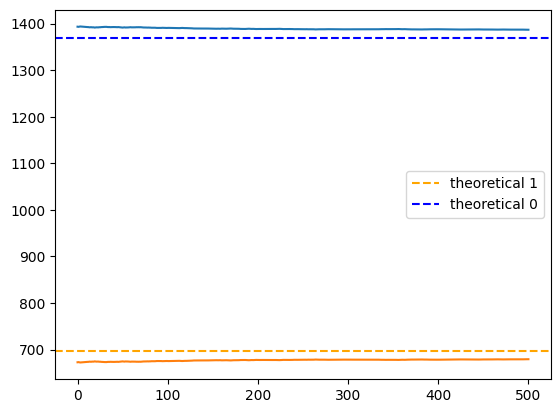

In [247]:
plt.plot(betweenes_node[:,GW.sens==0].sum(axis=1), label = 'Group 0')
plt.plot(betweenes_node[:,GW.sens==1].sum(axis=1), label = 'Group 1')
plt.axhline(y=MEAN_TH_BW*(GW.sens==1).nonzero().shape[0], color='orange',
            label='theoretical 1', linestyle='--')
plt.axhline(y=MEAN_TH_BW*(GW.sens==0).nonzero().shape[0], color='blue',
            label='theoretical 0', linestyle='--')
plt.legend()
plt.show()

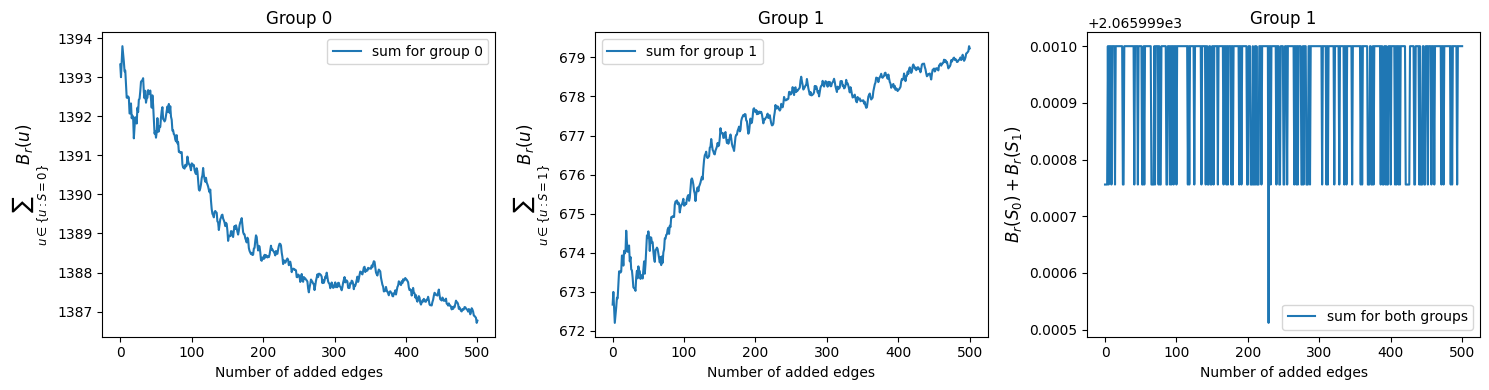

In [287]:
f, axs = plt.subplots(1,3, figsize=(15,4))
axs[0].plot(betweenes_node[:,GW.sens==0].sum(axis=1), label='sum for group 0')
axs[0].legend()
axs[0].set_title('Group 0')
axs[0].set_xlabel('Number of added edges')
axs[0].set_ylabel('$\sum_{u \in \{u: S=0\}} B_r(u)$', fontsize=12)

axs[1].plot(betweenes_node[:,GW.sens==1].sum(axis=1), label='sum for group 1')
axs[1].legend()
axs[1].set_title('Group 1')
axs[1].set_xlabel('Number of added edges')
axs[1].set_ylabel('$\sum_{u \in \{u: S=1\}} B_r(u)$', fontsize=12)

axs[2].plot(betweenes_node[:,GW.sens==1].sum(axis=1)+betweenes_node[:,GW.sens==0].sum(axis=1), label='sum for both groups')
axs[2].legend()
axs[2].set_title('Group 1')
axs[2].set_xlabel('Number of added edges')
axs[2].set_ylabel('$B_r(S_0) + B_r(S_1)$', fontsize=12)
plt.tight_layout()
plt.show()

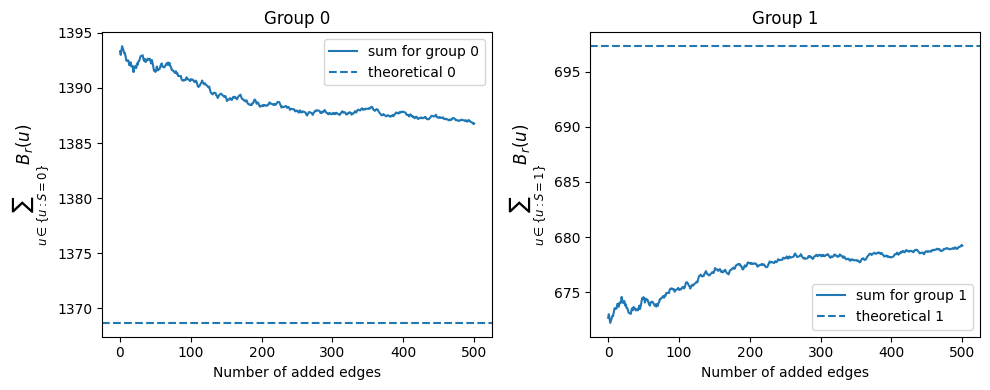

In [240]:
f, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(betweenes_node[:,GW.sens==0].sum(axis=1), label='sum for group 0')
axs[0].axhline(y=MEAN_TH_BW*(GW.sens==0).nonzero().shape[0], label='theoretical 0', linestyle='--')
axs[0].legend()
axs[0].set_title('Group 0')
axs[0].set_xlabel('Number of added edges')
axs[0].set_ylabel('$\sum_{u \in \{u: S=0\}} B_r(u)$', fontsize=12)

axs[1].plot(betweenes_node[:,GW.sens==1].sum(axis=1), label='sum for group 1')
axs[1].axhline(y=MEAN_TH_BW*(GW.sens==1).nonzero().shape[0],
            label='theoretical 1', linestyle='--')
axs[1].legend()
axs[1].set_title('Group 1')
axs[1].set_xlabel('Number of added edges')

axs[1].set_ylabel('$\sum_{u \in \{u: S=1\}} B_r(u)$', fontsize=12)
plt.tight_layout()
plt.show()

In [282]:
B0 = betweenes_node[-1,:]
B0.mean(), (B0/TOTAL_TH_BW).sum()


(tensor(1.9981), tensor(1.0000))

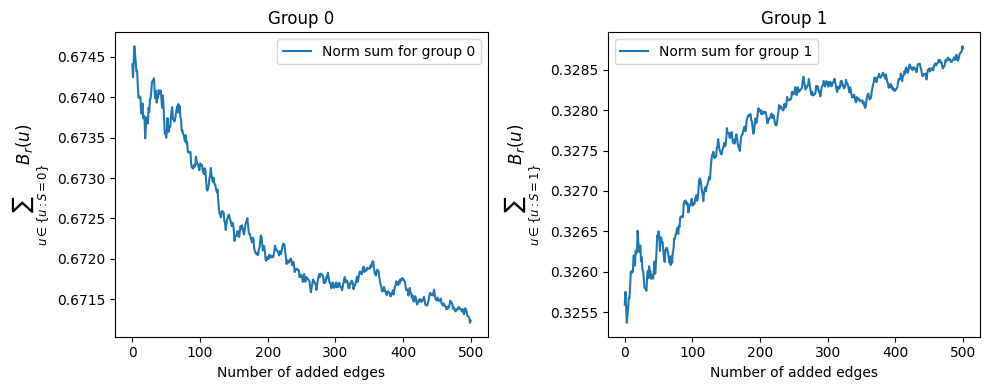

In [284]:
f, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot((betweenes_node[:,GW.sens==0]/TOTAL_TH_BW).sum(axis=1), label='Norm sum for group 0')
#axs[0].axhline(y=MEAN_TH_BW*(GW.sens==0).nonzero().shape[0], label='theoretical 0', linestyle='--')
axs[0].legend()
axs[0].set_title('Group 0')
axs[0].set_xlabel('Number of added edges')
axs[0].set_ylabel('$\sum_{u \in \{u: S=0\}} B_r(u)$', fontsize=12)

axs[1].plot((betweenes_node[:,GW.sens==1]/TOTAL_TH_BW).sum(axis=1), label='Norm sum for group 1')
#axs[1].axhline(y=MEAN_TH_BW*(GW.sens==1).nonzero().shape[0], label='theoretical 1', linestyle='--')
axs[1].legend()
axs[1].set_title('Group 1')
axs[1].set_xlabel('Number of added edges')

axs[1].set_ylabel('$\sum_{u \in \{u: S=1\}} B_r(u)$', fontsize=12)
plt.tight_layout()
plt.show()

## Mean betweeness

In [272]:
print('Original Graph')
B0 = betweenes_node[0,GW.sens==0]
B1 = betweenes_node[0,GW.sens==1]
print(f'Group 0 sum: {B0.mean():.2f} -- Normalized: {B0.mean()/MEAN_TH_BW:.5f}')
print(f'Group 1 sum: {B1.mean():.2f} -- Normalized: {B1.mean()/MEAN_TH_BW:.5f}')
print()


print(f'After {ADD_N_EDGES} edges added')
B0 = betweenes_node[-1,GW.sens==0]
B1 = betweenes_node[-1,GW.sens==1]
print(f'Group 0 sum: {B0.mean():.2f} -- Normalized: {B0.mean()/MEAN_TH_BW:.5f}')
print(f'Group 1 sum: {B1.mean():.2f} -- Normalized: {B1.mean()/MEAN_TH_BW:.5f}')
print()

Original Graph
Group 0 sum: 2.03 -- Normalized: 1.01801
Group 1 sum: 1.93 -- Normalized: 0.96465

After 500 edges added
Group 0 sum: 2.02 -- Normalized: 1.01322
Group 1 sum: 1.95 -- Normalized: 0.97405



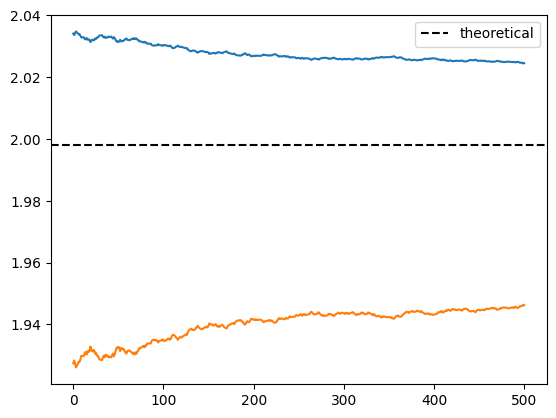

In [256]:
plt.plot(betweenes_node[:,GW.sens==0].mean(axis=1))
plt.plot(betweenes_node[:,GW.sens==1].mean(axis=1))
plt.axhline(y=MEAN_TH_BW, color='black',
            label='theoretical', linestyle='--')
plt.legend()
plt.show()

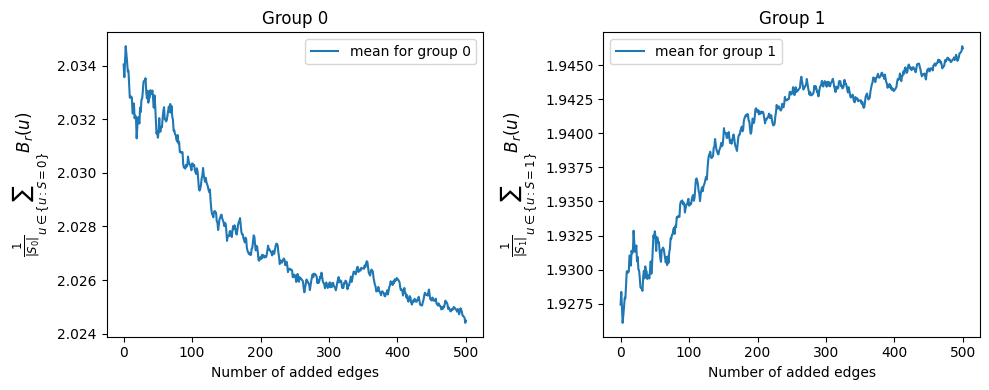

In [262]:
f, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(betweenes_node[:,GW.sens==0].mean(axis=1), label='mean for group 0')
axs[0].legend()
axs[0].set_title('Group 0')
axs[0].set_xlabel('Number of added edges')
axs[0].set_ylabel(r'$\frac{1}{|S_0|} \sum_{u \in \{u: S=0\}} B_r(u)$', fontsize=12)

axs[1].plot(betweenes_node[:,GW.sens==1].mean(axis=1), label='mean for group 1')
axs[1].legend()
axs[1].set_title('Group 1')
axs[1].set_xlabel('Number of added edges')
axs[1].set_ylabel(r'$\frac{1}{|S_1|}\sum_{u \in \{u: S=1\}} B_r(u)$', fontsize=12)
plt.tight_layout()
plt.show()

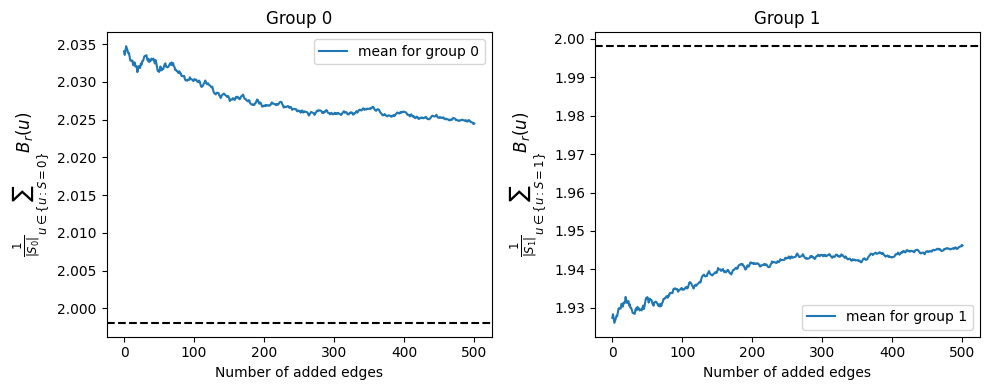

In [265]:
f, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(betweenes_node[:,GW.sens==0].mean(axis=1), label='mean for group 0')
axs[0].legend()
axs[0].set_title('Group 0')
axs[0].set_xlabel('Number of added edges')
axs[0].set_ylabel(r'$\frac{1}{|S_0|} \sum_{u \in \{u: S=0\}} B_r(u)$', fontsize=12)
axs[0].axhline(y=MEAN_TH_BW, color='black',
            label='theoretical', linestyle='--')

axs[1].plot(betweenes_node[:,GW.sens==1].mean(axis=1), label='mean for group 1')
axs[1].legend()
axs[1].set_title('Group 1')
axs[1].set_xlabel('Number of added edges')
axs[1].set_ylabel(r'$\frac{1}{|S_1|}\sum_{u \in \{u: S=1\}} B_r(u)$', fontsize=12)
axs[1].axhline(y=MEAN_TH_BW, color='black',
            label='theoretical', linestyle='--')
plt.tight_layout()
plt.show()